# DRAVOGRAD- DRAVA RIVER

19/10/2021

In this notebook results of different feature selections are compared for the Dravograd Basin (of which we have around 40 years of data)

Input data are ERA5 metereological reanalysis quantile mapped and downscaled by ZAMG.

Time averages over the (for the previous year) of pecipitation, temperature and potential evapotranspiration are selected as input.

The settings are the following:

    A) 180 features are selected with PCA, the same numeriosity as setting C) ;

    B) 36 features are selectedwith PCA, the same numeriosity as setting D) ;
        
    C) metereological inputs spatial statistics are used as input: mean, the 5th, 25th, 75th and 95th quantiles are selected.
        
    D) metereological inputs are spatially averaged.


In [2]:
from sf_runoff import daily_climatology, spatial_avg_daily_input, spatial_stats_daily_input, compute_anomalies
from nested_CV import SVR_nested_CV_gridsearch, SVR_PCA_nested_CV_gridsearch
from test import evaluate_prediction, plot_prediction, plot_anomalies
from test import nested_CV_PCA_SVR_predict, nested_CV_SVR_predict
from classic_CV_predict import classic_CV_PCA_SVR_predict, classic_CV_SVR_predict


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt

import os

import pdb
import seaborn as sns

In [3]:
path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'

daily_input = pd.read_csv(path+'HEDravograd_Drava_1952_2019.txt', index_col=0, parse_dates=True).astype('float32')

daily_input_TPE = spatial_avg_daily_input(daily_input)

daily_input_stat = spatial_stats_daily_input(daily_input)

In [4]:
daily_input


Q         T20         T65         T66         T67  \
1979-01-01  134.000000  270.337860  269.533844  269.643250  270.126678   
1979-01-02  209.000000  259.806458  257.556824  257.838806  259.198822   
1979-01-03  142.000000  255.524170  253.791412  253.451279  253.861832   
1979-01-04  281.000000  255.423065  253.186661  253.195053  254.407028   
1979-01-05  287.000000  258.856171  255.140869  256.244293  258.958954   
...                ...         ...         ...         ...         ...   
2018-12-27  187.875000  272.024536  272.229309  272.078613  271.985748   
2018-12-28  161.899994  272.674316  273.125824  273.058472  272.962677   
2018-12-29  113.217003  272.957764  273.255035  273.311371  273.127655   
2018-12-30  121.758003  272.662445  272.893860  272.875671  272.631195   
2018-12-31  133.358002  272.690369  272.644836  272.678619  272.577698   

                  T112        T113        T114        T115        T121  ...  \
1979-01-01  268.652283  269.486298  269.317230  269.105804  269.971375  ...   
1979-01-02  257.777466  257.979279  257.140717  257.285461  259.517761  ...   
1979-01-03  253.181046  252.824493  252.143723  251.699570  254.879211  ...   
1979-01-04  252.095627  252.483002  252.526672  252.278503  256.901031  ...   
1979-01-05  254.906265  256.676117  257.198242  257.186737  260.520081  ...   
...                ...         ...         ...         ...         ...  ...   
2018-12-27  271.207214  271.671204  271.505188  271.404297  271.204865  ...   
2018-12-28  272.298096  272.900696  273.002563  272.759003  271.892883  ...   
2018-12-29  272.316833  272.934662  272.968201  272.678589  271.573120  ...   
2018-12-30  271.747375  272.404846  272.216431  272.101562  271.734619  ...   
2018-12-31  271.690826  272.374817  272.258667  272.142334  272.971710  ...   

                E767      E768      E769      E770      E772      E773  \
1979-01-01  0.076270  0.098717  0.184784  0.165689  0.095762  0.241477   
1979-01-02  0.047949  0.054136  0.097055  0.158136  0.061804  0.217116   
1979-01-03 -0.007272  0.009058  0.044851  0.072568  0.037061  0.071960   
1979-01-04 -0.141226 -0.140258 -0.094206 -0.092128 -0.109595 -0.094535   
1979-01-05 -0.089553 -0.109411 -0.031876 -0.040326 -0.115176 -0.059815   
...              ...       ...       ...       ...       ...       ...   
2018-12-27 -0.034306 -0.040950  0.156138  0.142231  0.078009  0.099049   
2018-12-28 -0.002034 -0.017229  0.110131  0.075766 -0.031935 -0.036371   
2018-12-29 -0.129721 -0.164444 -0.223987 -0.217528 -0.224338 -0.024739   
2018-12-30  0.123074  0.145322  0.467134  0.428947  0.163033  0.469522   
2018-12-31  0.054623  0.050858  0.365765  0.326824 -0.102772  0.427378   

                E813      E814      E815           T  
1979-01-01  0.034289  0.105241  0.191938  266.851776  
1979-01-02 -0.004516  0.031896  0.112937  256.017822  
1979-01-03 -0.062477 -0.045287  0.002136  253.567688  
1979-01-04 -0.198484 -0.165326 -0.099964  253.346390  
1979-01-05 -0.119176 -0.111551 -0.037148  254.808685  
...              ...       ...       ...         ...  
2018-12-27 -0.103848 -0.038043  0.196894  269.764618  
2018-12-28 -0.049602  0.007567  0.167646  271.553711  
2018-12-29 -0.183187 -0.187151 -0.228011  270.671936  
2018-12-30  0.054215  0.141186  0.387892  270.781158  
2018-12-31  0.009097  0.071425  0.255817  271.890015  

[14610 rows x 1517 columns]

import sys, importlib
importlib.reload(sys.modules['test'])


In [5]:
#define the possible parameters value (where Gridsearch is applied)

C_range=np.logspace(-2, 2, 10)
epsilon_range=np.logspace(-6, -2, 5)
#n_range = [17, 50, 200]
components_range = [5*3*12]
#do not enlarge t_range for now

t_range=[12]

#define the temporal unit
t_unit=30
t_range=[12]
n_splits=10
test_size=365

# A) PCA+SVR

### TRAIN A PCA+SVR MODEL 

Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits
Fitting 1 folds for each of 50 candidates, totalling 50 fits

C=0.21544346900318834
eps=0.01
n=180


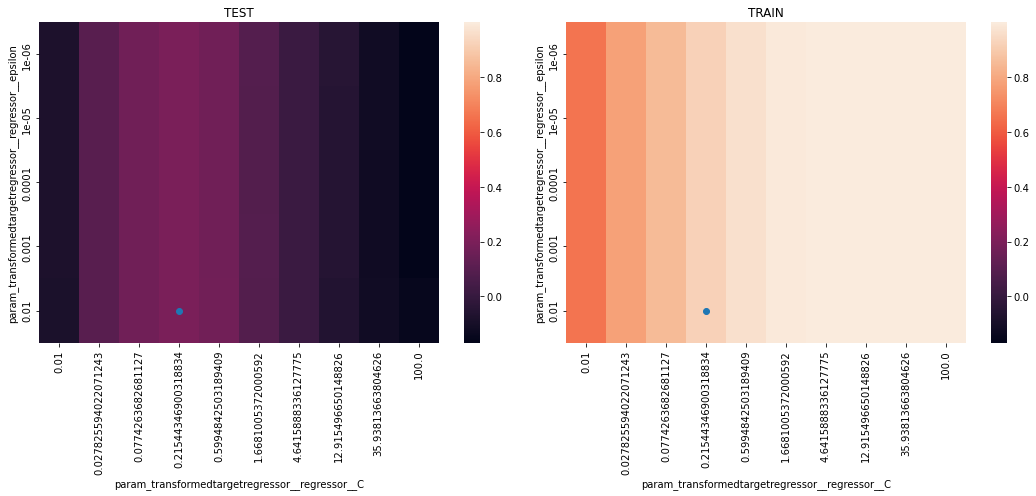

In [5]:
C,eps,n=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range, t_range,t_unit,n_splits,test_size)
print(f'C={C}')
print(f'eps={eps}')
print(f'n={n}')

r2_PCA180_an = evaluate_prediction(a)

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [6]:
radius_for_ensemble = 0.9
predictions = nested_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

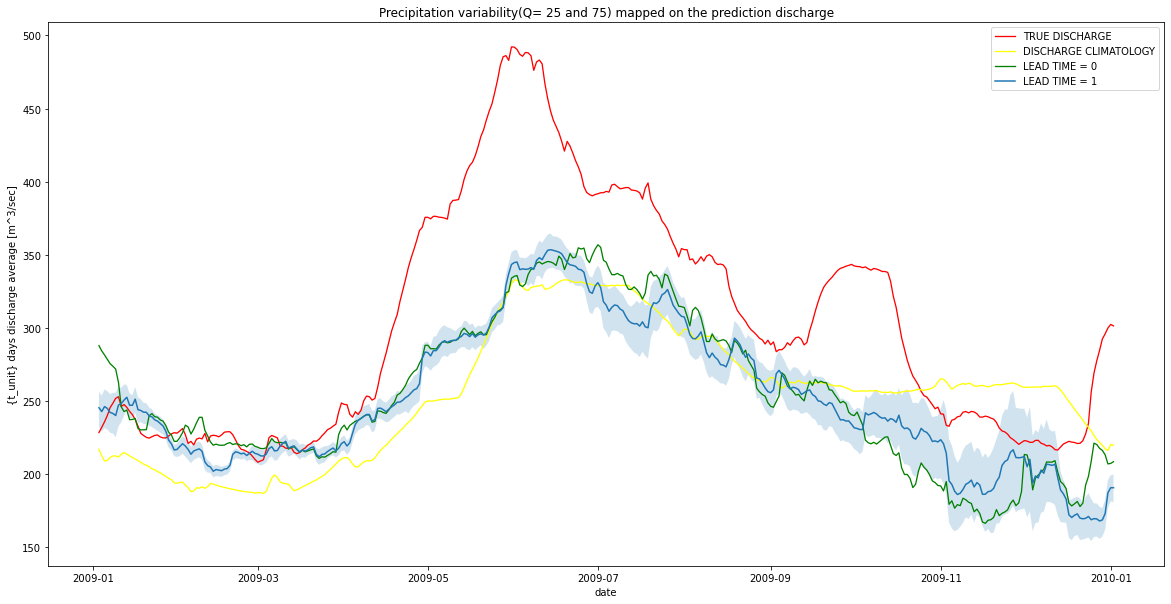

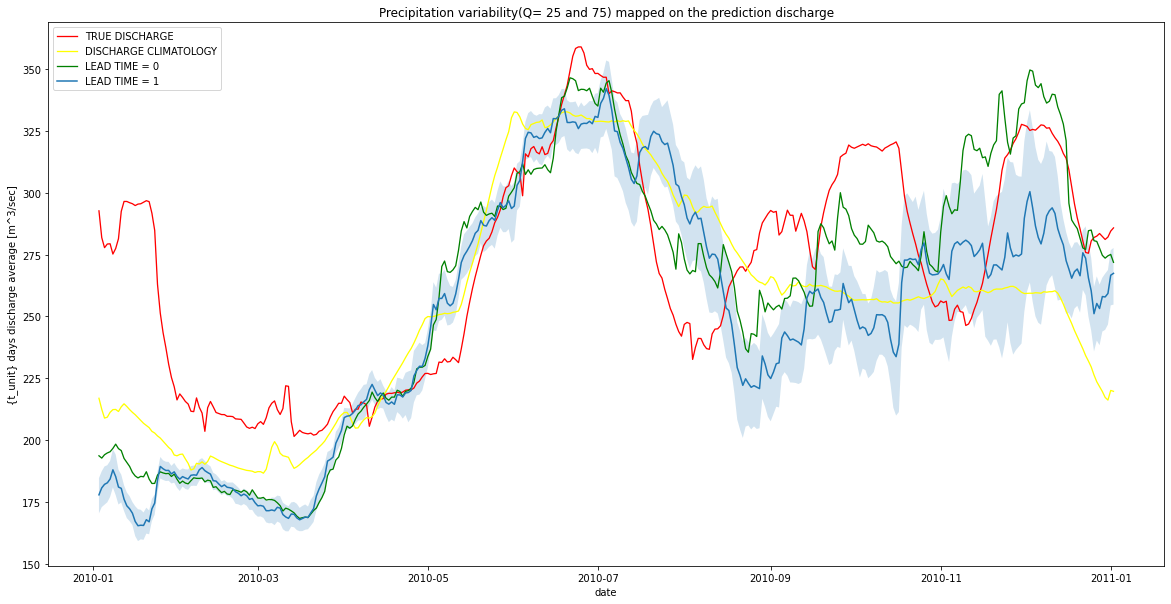

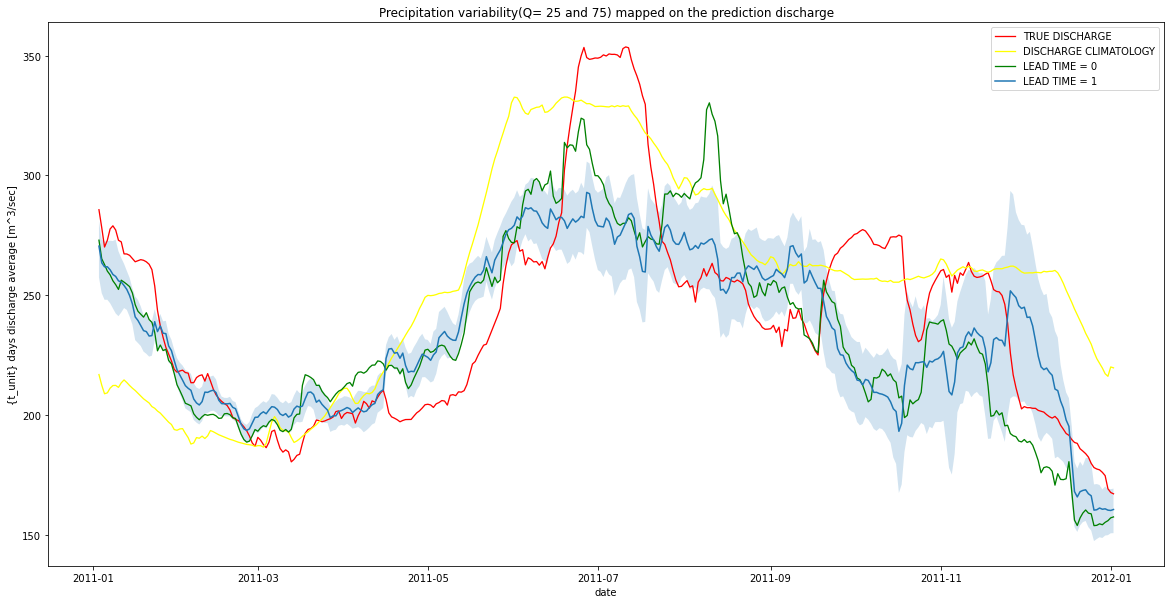

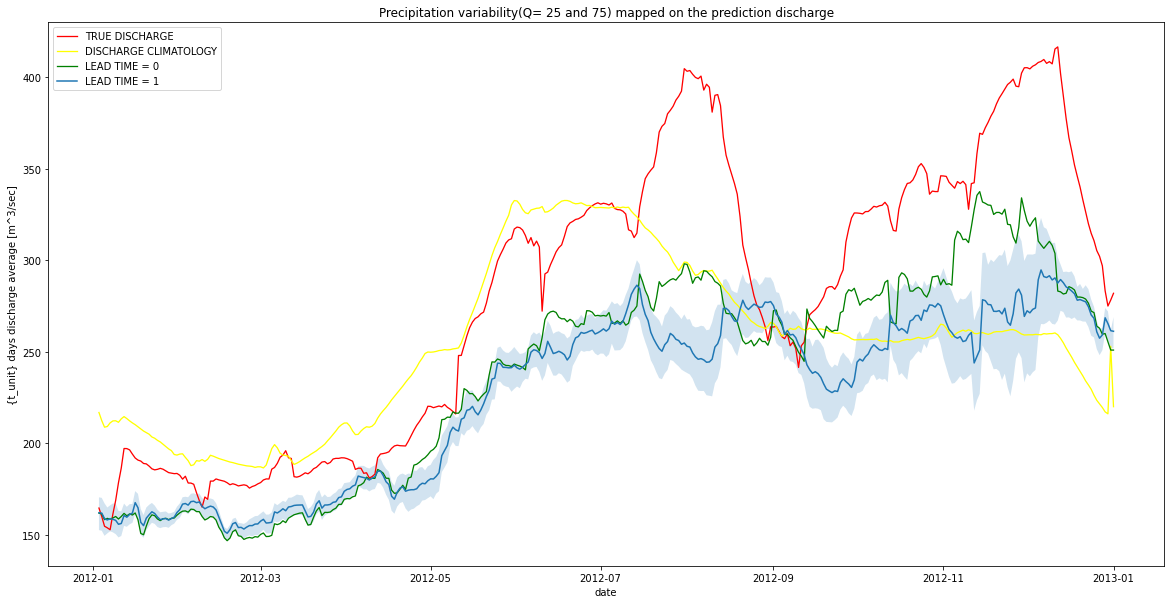

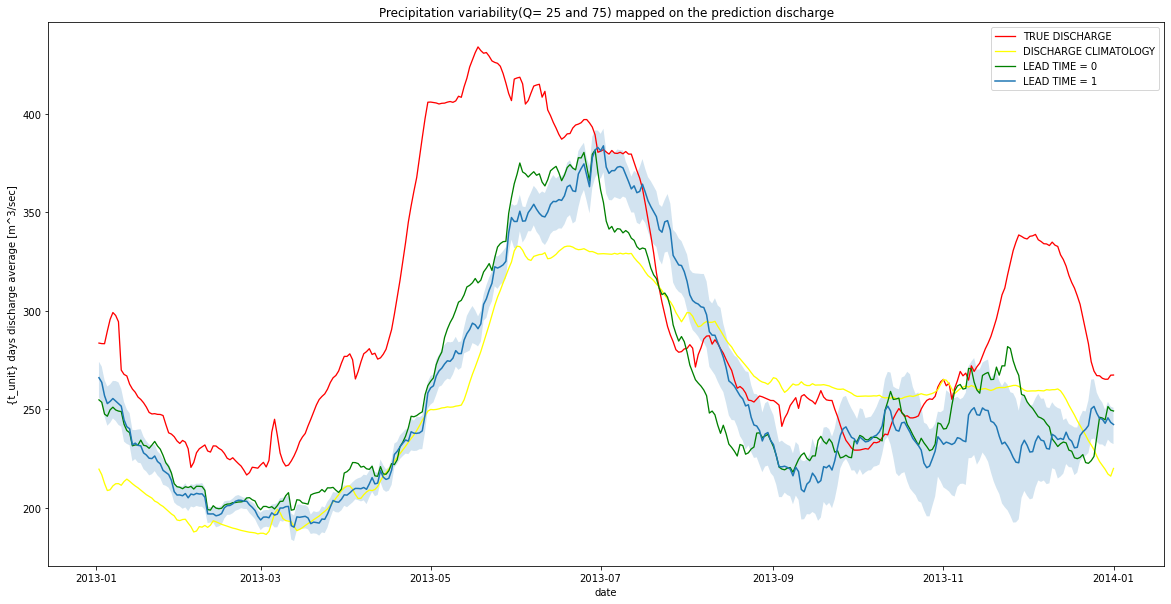

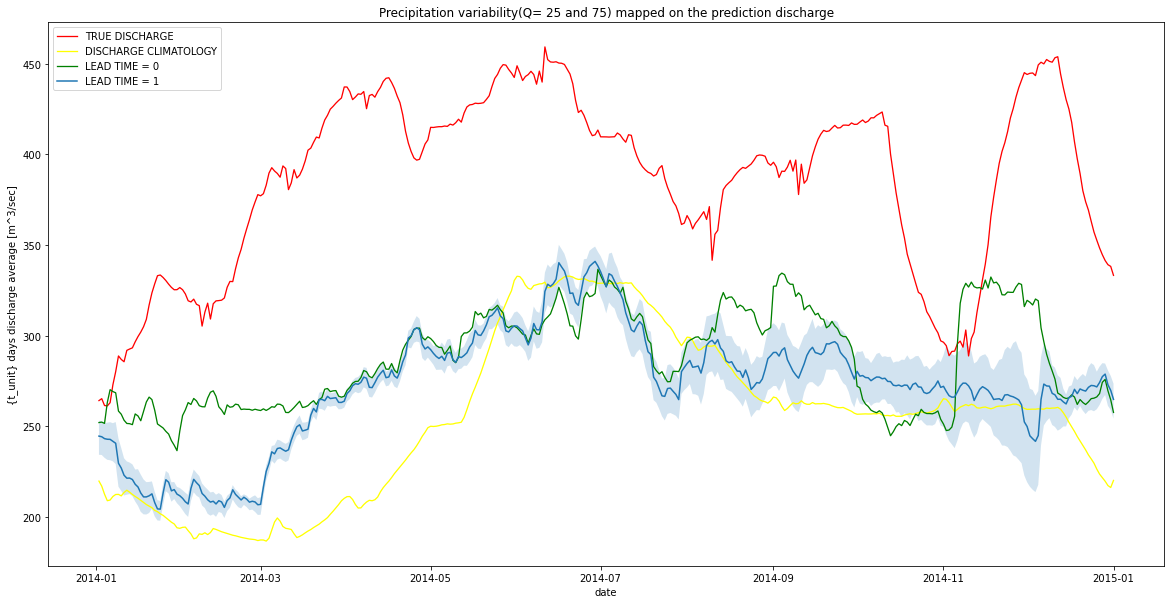

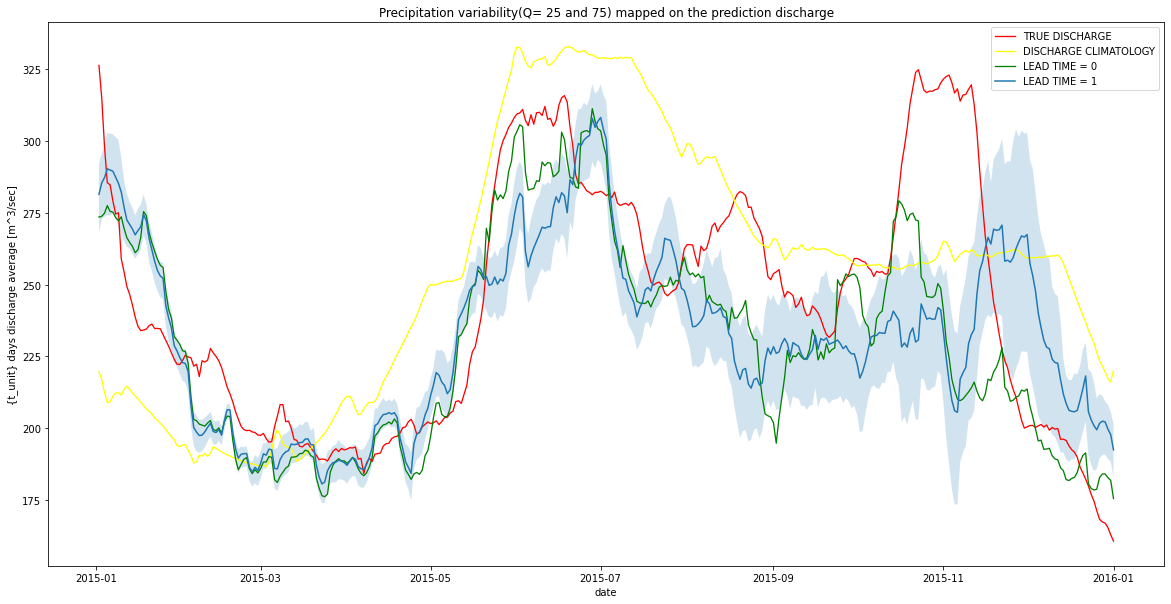

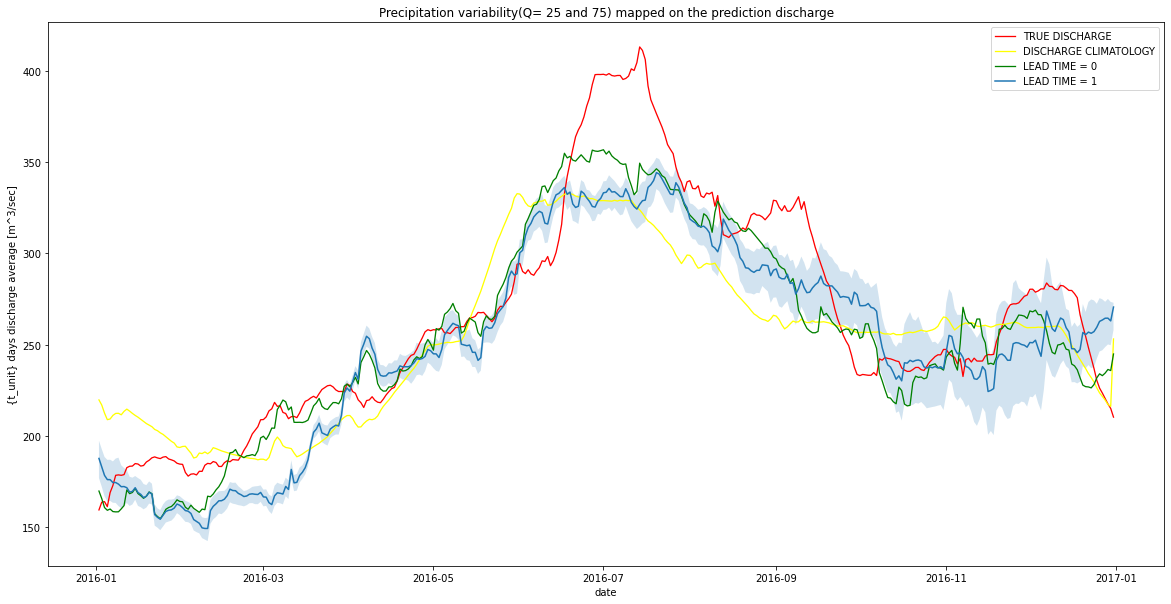

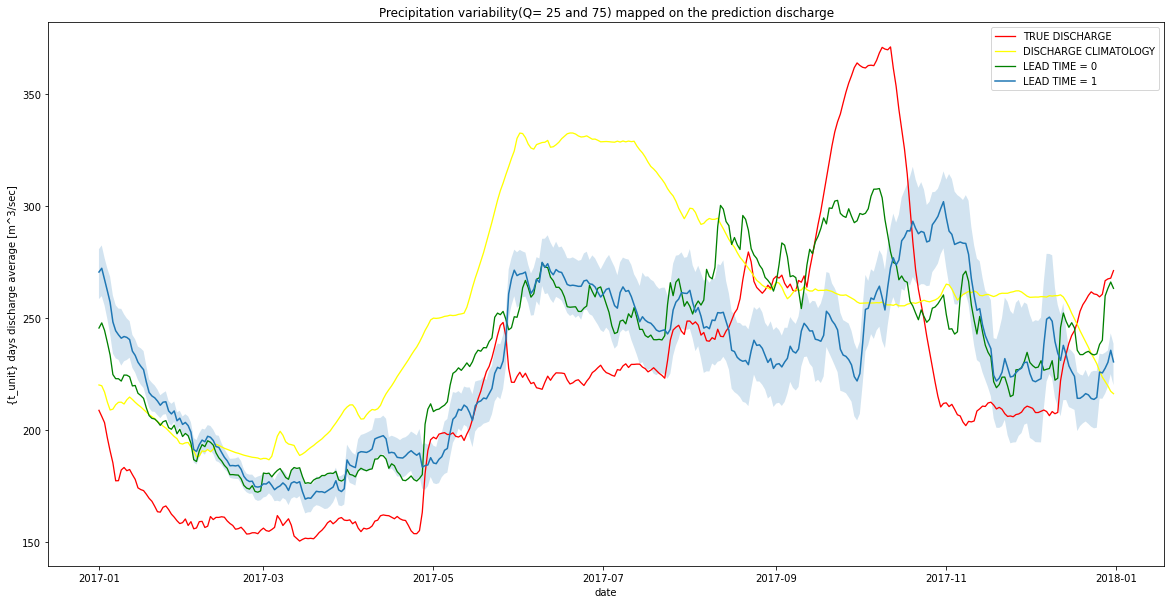

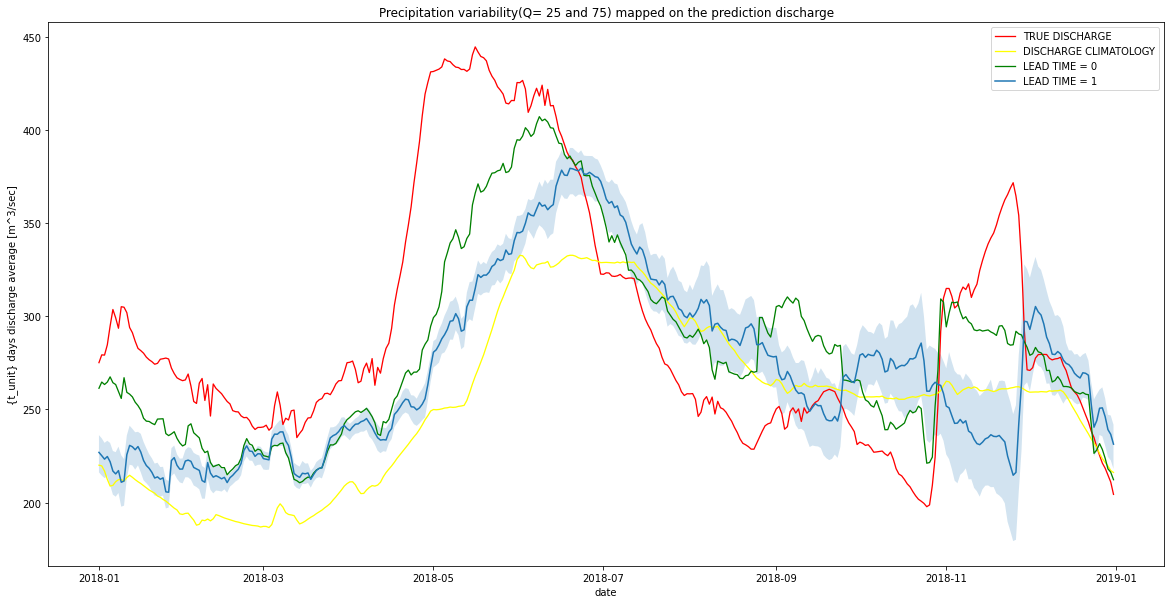

In [7]:
plot_prediction(predictions,t_unit)

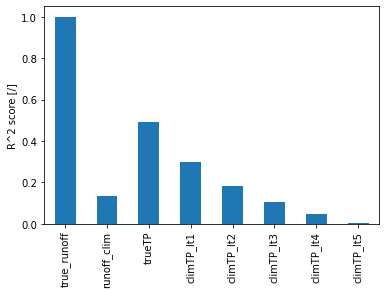

In [8]:
r2_PCA180 = evaluate_prediction(predictions)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [9]:
predictions_for_clim = classic_CV_PCA_SVR_predict(daily_input, C, eps, n, 12,t_unit, n_splits)

In [10]:
climatologies =predictions_for_clim.groupby(by=predictions_for_clim.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies['doty']=climatologies.index


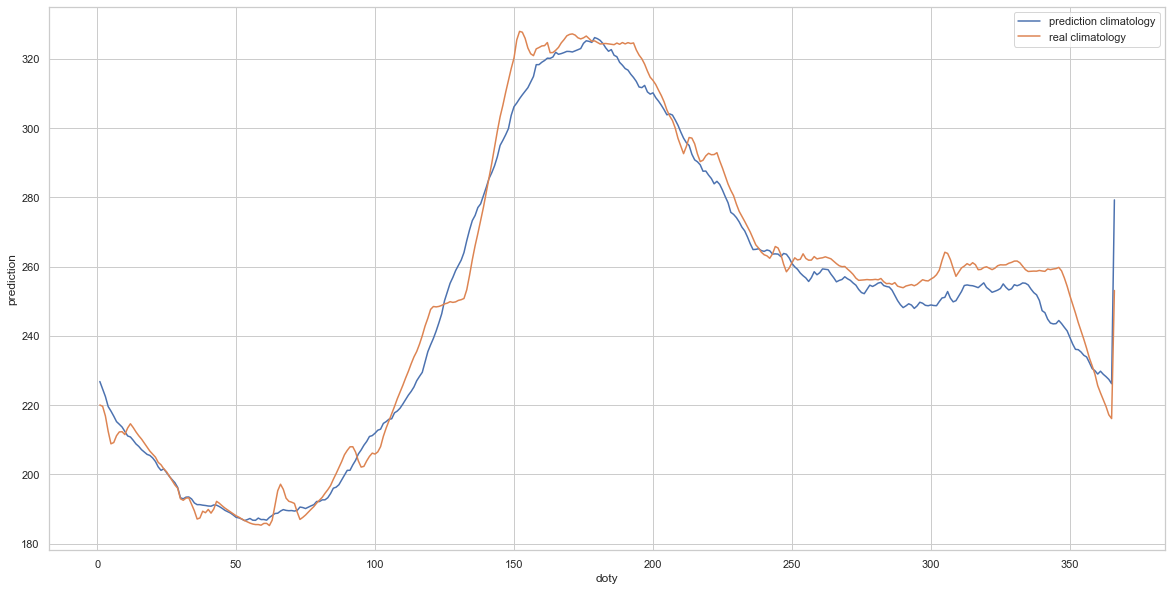

In [11]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [12]:
a=compute_anomalies(climatologies, predictions)


In [13]:
a['split']=predictions.split

C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\mmazzolini\.conda\envs\ado\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

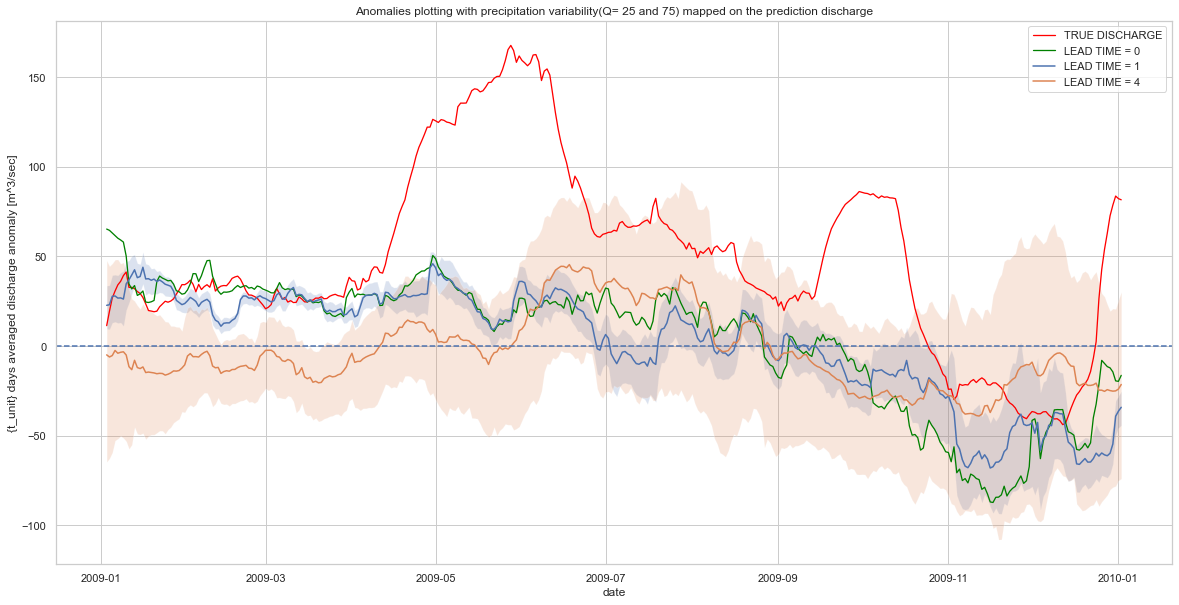

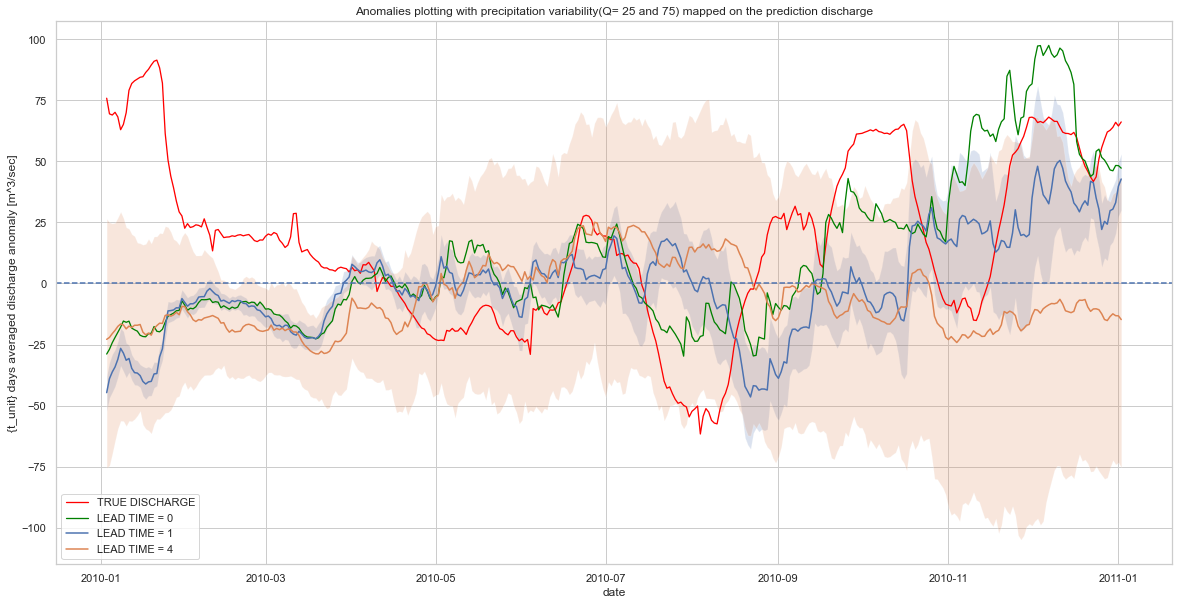

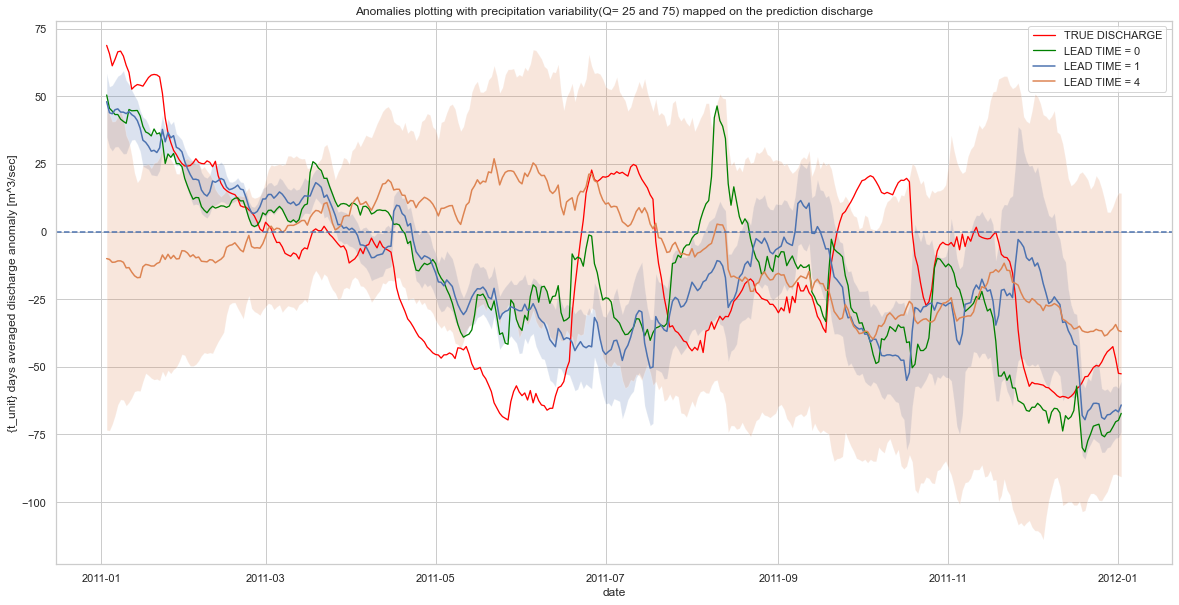

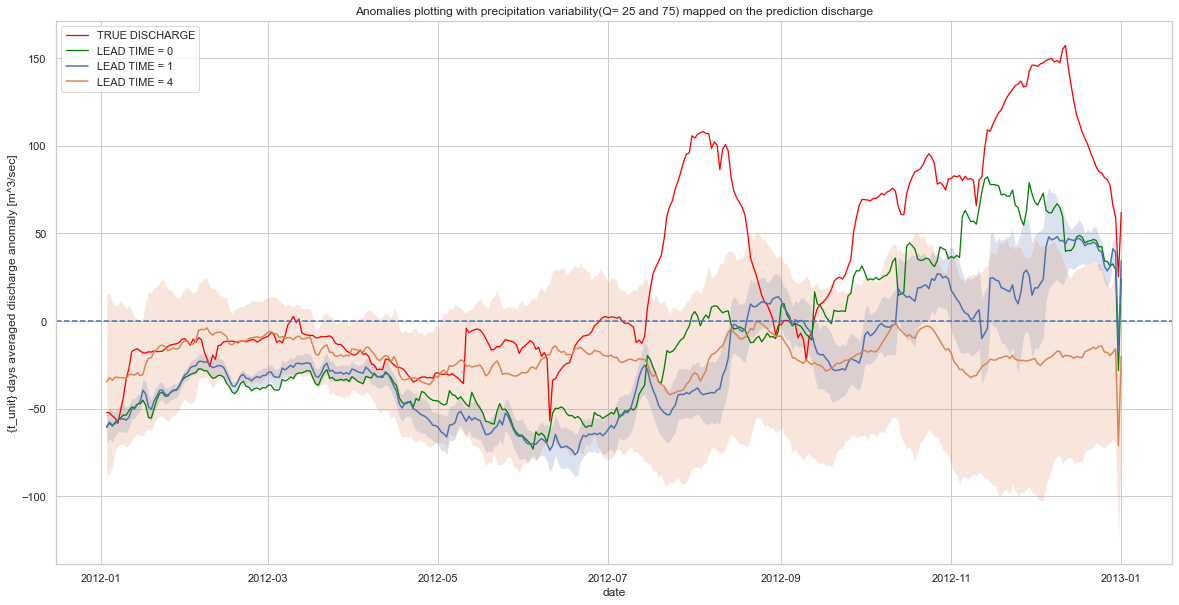

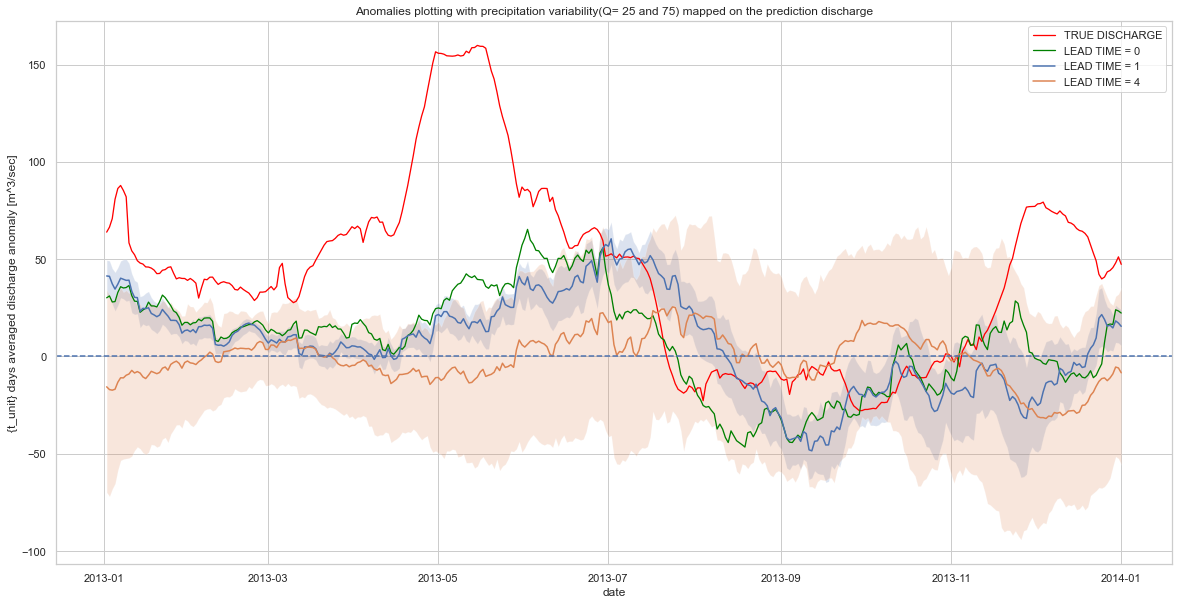

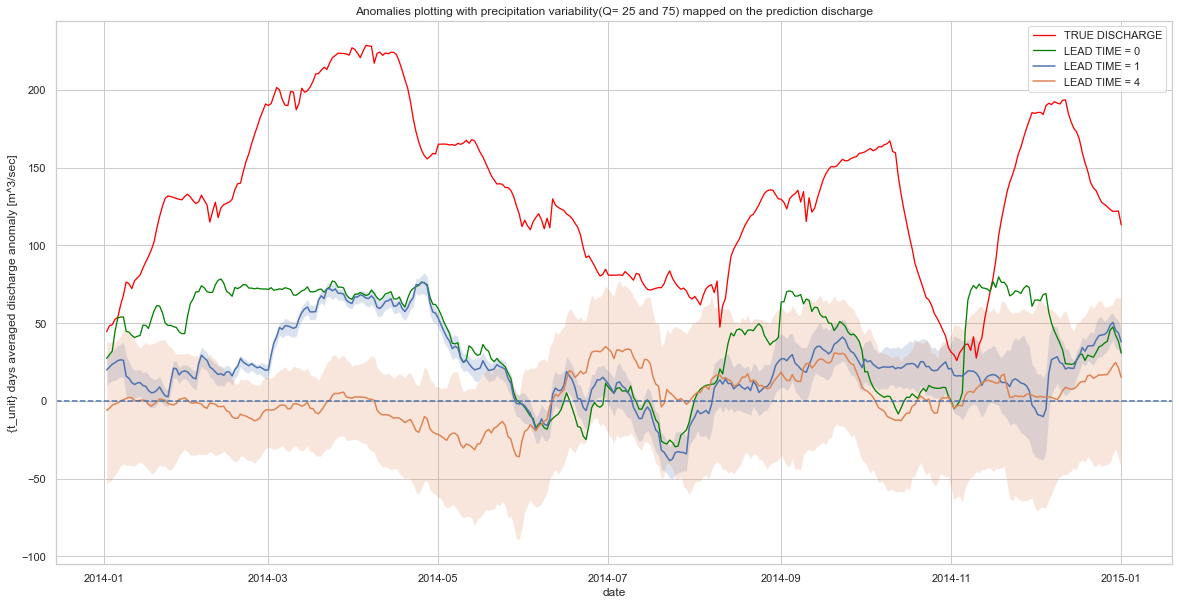

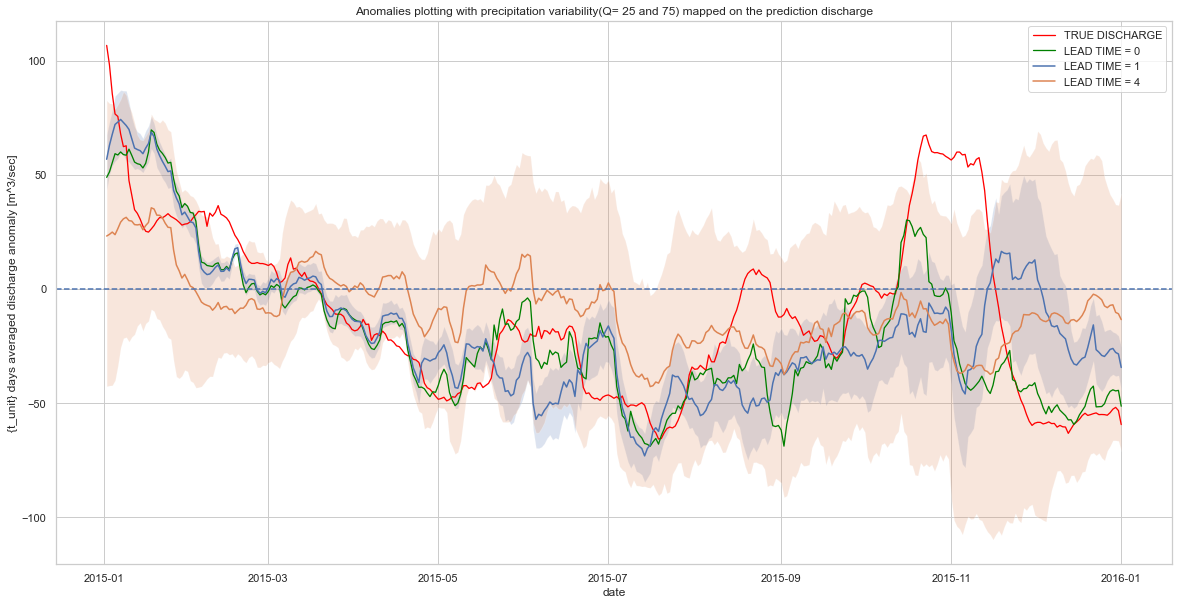

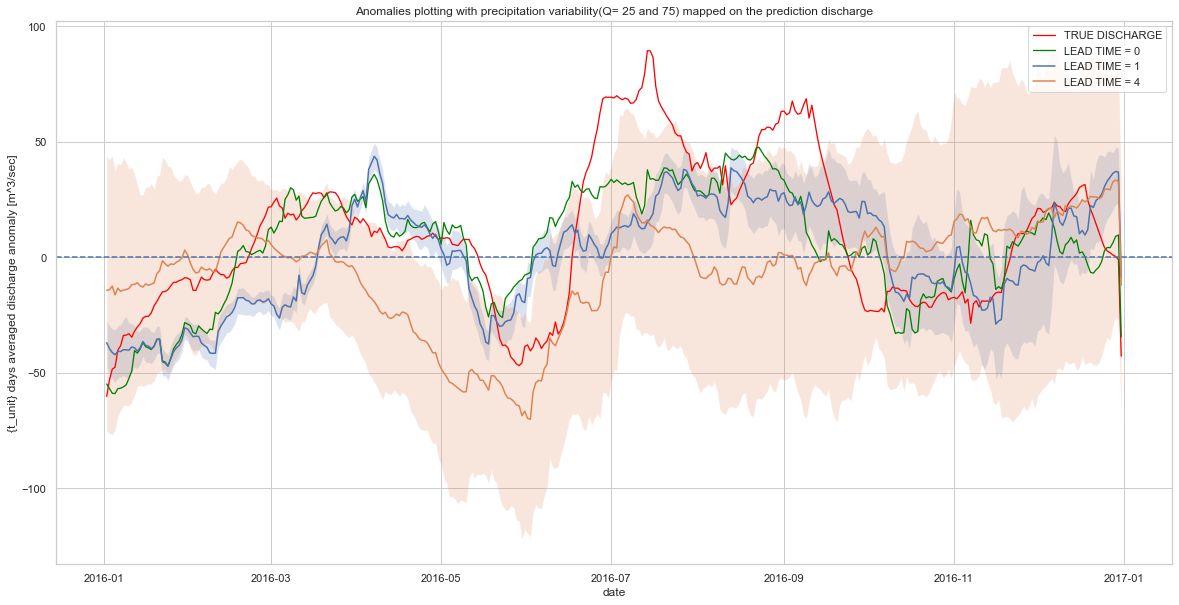

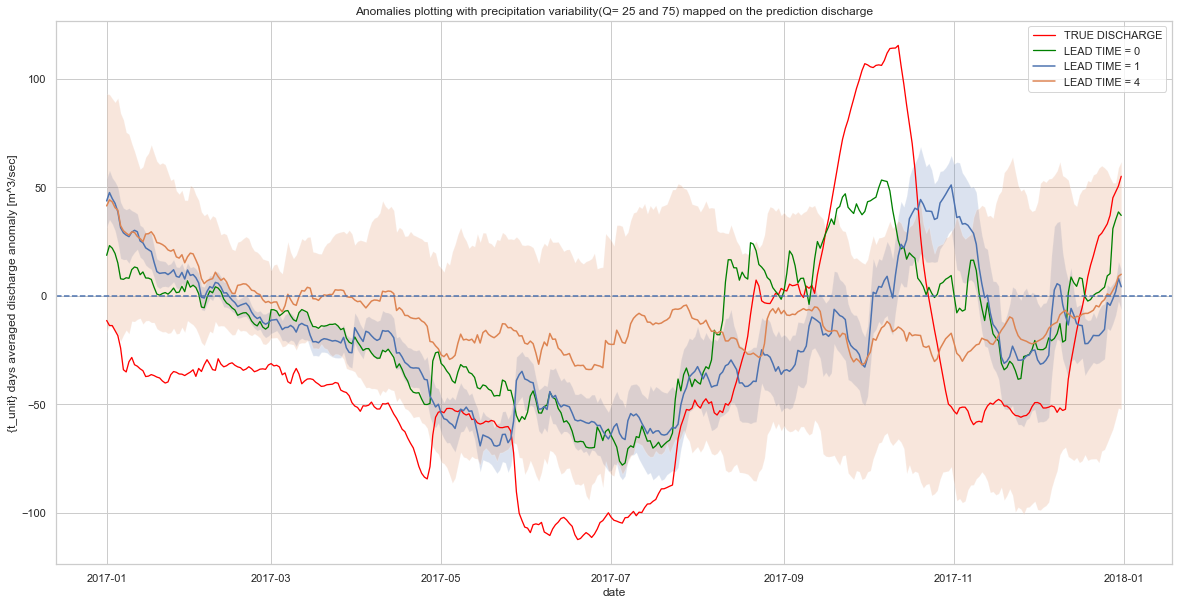

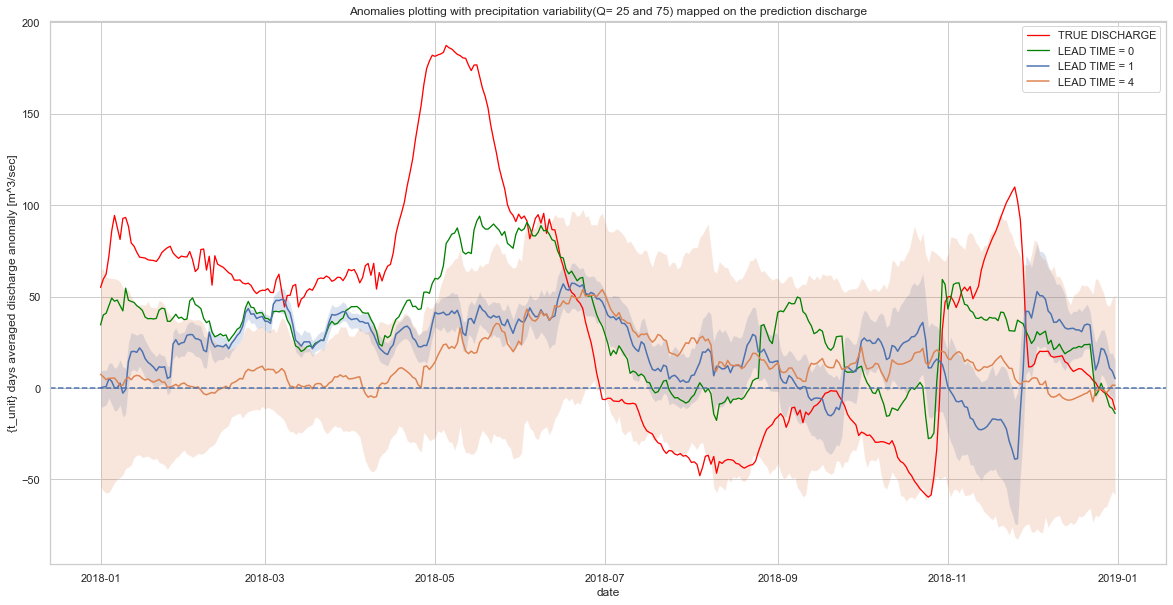

In [14]:
plot_anomalies(a,t_unit)

## B) PCA+SVR 

### TRAIN A PCA+SVR MODEL 

In [ ]:
components_range2=[12*3]
C2,eps2,n2=SVR_PCA_nested_CV_gridsearch(daily_input, C_range,  epsilon_range, components_range2, t_range,t_unit,n_splits,test_size)
print(f'C={C2}')
print(f'epsilon={eps2}')
print(f'n={n2}')

Fitting 1 folds for each of 50 candidates, totalling 50 fits


C2  =0.5994842503189409
eps2=10e-06
n2  =36

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
predictions2 = nested_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12,t_unit, n_splits, test_size, radius_for_ensemble)

predictions=pd.read_csv('tial.csv',date_parser=True)

In [ ]:
plot_prediction(predictions2,t_unit)

In [ ]:
r2_PCA36 = evaluate_prediction(predictions2)
#r2_PCA = evaluate_prediction(predictions.iloc[:,1:])

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim2 = classic_CV_PCA_SVR_predict(daily_input, C2, eps2, n2, 12,t_unit, n_splits)

In [ ]:
climatologies2 =predictions_for_clim2.groupby(by=predictions_for_clim2.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies2['doty']=climatologies2.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies2,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies2,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a2=compute_anomalies(climatologies2, predictions2)
a2['split']=predictions2.split

plot_anomalies(a2,t_unit)

# C) SVR 
## WITH SPATIAL STATISTICS AS INPUT

In [ ]:
C3, eps3 = SVR_nested_CV_gridsearch(daily_input_stat, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C3={C3}')
print(f'eps3={eps3}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
predictions3 = nested_CV_SVR_predict(daily_input_stat, C3, eps3, 12, t_unit, n_splits, test_size, radius_for_ensemble)

In [ ]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions3,t_unit)

In [ ]:
r2_STATS= evaluate_prediction(predictions3)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim3 = classic_CV_SVR_predict(daily_input_stat, C3, eps3, 12,t_unit, n_splits)

In [ ]:
climatologies3 =predictions_for_clim3.groupby(by=predictions_for_clim3.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies3['doty']=climatologies3.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies3,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies3,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a3=compute_anomalies(climatologies3, predictions3)

a3['split']=predictions3.split
plot_anomalies(a3,t_unit)

# D) SVR 
## WITH SPATIAL AVERAGE AS INPUT

In [ ]:
C4, eps4 = SVR_nested_CV_gridsearch(daily_input_TPE, C_range,epsilon_range, t_range,t_unit,n_splits,test_size)
print(f'C4={C4}')
print(f'eps4={eps4}')

### PREDICT RUNOFF ON TEST SET AND QUANTIFY THE PERFORMANCE

In [ ]:
radius_for_ensemble = 1
predictions4 = nested_CV_SVR_predict(daily_input_stat, C4, eps4, 12, t_unit, n_splits, test_size, radius_for_ensemble)

In [ ]:
#predictions=pd.read_csv('tial.csv',date_parser=True)
plot_prediction(predictions4, t_unit)

In [ ]:
r2_TPE = evaluate_prediction(predictions4)

### ANALYSE RESULTS AS ANOMALIES

### 1) PREDICT THE WHOLE SERIES WITH CLASSIC CV

In [ ]:
predictions_for_clim4 = classic_CV_SVR_predict(daily_input_stat, C4, eps4, 12,t_unit, n_splits)

In [ ]:
climatologies4 =predictions_for_clim4.groupby(by=predictions_for_clim4.index.day_of_year).mean().loc[:,['prediction','true_runoff']]
climatologies4['doty']=climatologies4.index


In [ ]:
sns.set_theme(style="whitegrid")
ax,fig=plt.subplots(figsize=(20,10))
sns.lineplot(data=climatologies4,x='doty',y='prediction',label='prediction climatology')
sns.lineplot(data=climatologies4,x='doty',y='true_runoff',label='real climatology')
plt.legend()

### 2) COMPUTE THE ANOMALIES AND PLOT THEM

In [ ]:
a4=compute_anomalies(climatologies4, predictions4)
a4['split']=predictions4.split
plot_anomalies(a4,t_unit)

# COMPARE RESULTS

In [ ]:
results = pd.concat([r2_PCA180,r2_PCA36,r2_TPE,r2_STATS,],axis=1)
results.columns=['A) PCA(180)','B) PCA(180)','C) TPE_STATS','D) TPE_AVG']

In [ ]:
results.iloc[2:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

### FOR ANOMALIES RESULTS

In [ ]:
r2_TPE_an = evaluate_prediction(a4)
r2_STATS_an= evaluate_prediction(a3)
r2_PCA36_an = evaluate_prediction(a2)
r2_PCA180_an = evaluate_prediction(a)

In [ ]:
results = pd.concat([r2_PCA180_an,r2_PCA36_an,r2_STATS_an,r2_TPE_an],axis=1)
results.columns=['A) PCA(180)','B) PCA(36)','C) TPE_STATS','D) TPE_AVG']
results.iloc[1:].plot.bar()
plt.title('R^2 RESULTS COMPARISON')
plt.ylabel('r^2 [/]')

In [1]:
r2_PCA180_an = evaluate_prediction(a)

NameError: name 'evaluate_prediction' is not defined